In [1]:
"""
Python code for Maximum likelihood esimation and Maximum A Posteriori (MAP) Parameter Estimation
"""
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import Normal

Let us suppose that we know that the height of an adult resident in Statsville lies between 160 cm and 170 cm.
We want to predict if this resident is female. For this purpose, we have collected a set of height samples from adult female residents in Statsville. This becomes our training data. From physical considerations, we can assume that the distribution of heights is Gaussian. Our goal is to estimate the parameters ($\mu$, $\sigma$) of this Gaussian. In this notebook, we will study two ways of doing this (1) Maximum Likelihood Estimation and (2) Maximum A Posteriori Estimation.

Let us first create the dataset $X$ by sampling 10000 points from a Gaussian distribution with $\mu$=152 and $\sigma$=8. In real life scenarios, we do not know the mean and standard deviation of the true distribution. But for the sake of this example, let's assume that the mean height is 152cm and standard deviation is 50cm.

In [2]:
torch.random.manual_seed(42)
num_samples = 10000
mu = 152
sigma = 8
X = torch.normal(mu, sigma, size=(num_samples, 1))
print('Dataset shape: {}'.format(X.shape))

Dataset shape: torch.Size([10000, 1])


## Maximum Likelihood Estimate (MLE)

In MLE, we try to find the parameters that "best explain" our data. In other words, we try to find the parameters that maximize the joint likelihood of our training data instances. 

Let's say our model is parameterised by $\theta$. The likelihood function $p(X|\theta)$ shows how likely the sample distribution $X$ is for different values of $\theta$. With MLE, our goal is to find the parameters $\theta$ that maximise $p(X|\theta)$. 

We can assume that our model parameterises a Gaussian distribution $N(\mu, \sigma)$
The likelihood function can be written as 
    $$ p(X|\theta) = N(X|\mu,\sigma) = \prod_{i=1}^{n}N(x_i|\mu,\sigma) = 
    \Bigl(\frac{1}{2\pi\sigma^2}\Bigl)^\frac{N}{2}exp\Bigl(\frac{-1}{2\sigma^2}\sum_{i=1}^N(x_i - \mu)^2\Bigl) $$
Maximising the likelihood function yields 
$$\mu_{MLE} = \frac{1}{N}\sum_{i=1}^nx_i$$
$$\sigma_{MLE} = \frac{1}{N}\sum_{i=1}^n(x_i - \mu)^2$$

In practice, we maximise the logarithm of the likelihood because it makes for much easier calculations when dealing with exponential functions. Refer to the section 6.8 in the book for a detailed derivation

Thus by computing the sample mean and the sample standard deviation, we can find the parameters of the best fit Gaussian for the dataset. Once we estimate the parameters, we can find out the probability that a sample lies in the range using the following formula
$$ p(a < X <= b) = \int_{a}^b p(X) dX $$

In [3]:
# Let us compute the mean and standard deviation of the sampled points.
sample_mean = X.mean()
sample_std = X.std()

print('Sample mean: {}'.format(sample_mean))
print('Sample standard deviation: {}'.format(sample_std))

# As expected, the sample mean and sample standard deviation are close to the corresponding values 
# of the Normal distribution that the points were sampled from

gaussian_mle = Normal(sample_mean, sample_std)

# We want to find out the probability that a height between 160 and 170 belongs to an adult female resident
a, b = torch.Tensor([160]), torch.Tensor([170])

prob = gaussian_mle.cdf(b) - gaussian_mle.cdf(a)
print('Prob: {}'.format(prob))

Sample mean: 152.05154418945312
Sample standard deviation: 8.035674095153809
Prob: tensor([0.1485])


In [4]:
a, b = torch.Tensor([160]), torch.Tensor([170])
prob = gaussian_mle.cdf(b) - gaussian_mle.cdf(a)

### Maximum Likelihood Estimate using Gradient Descent
Above, we were able to estimate the parameters using the closed form solution. Now, let us try to arrive at these parameters iteratively using gradient descent. In real-life scenarios, we don't use gradient descent because the closed form solution is available. But we discuss the gradient descent based approach to highlight some of the challenges.

Our objective is to find the parameters $\theta$ that maximise the likelihood function $p(X|\theta)$. We choose to maximise the log of the likelihood function since it is more mathematically convenient. This can alternatively viewed as minimising the negative log-likelihood function.

$$ -\log p(X|\theta) = \frac{N}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}\sum_{i=1}^n(x_i - \mu)^2$$

The optimisation process is as follows:
 1. Initialise the model parameters, $\mu$ and $\sigma$ with random values
 2. Compute the loss value (negative log-likelihood)
 3. Find the gradients of the loss w.r.t the model parameters
 4. Update the model parameters in the opposite direction of the gradient values
 5. Repeat steps 1-4 until loss diminishes to a small value

In [5]:
import torch
from torch.autograd import Variable

dtype = torch.FloatTensor

# Negative log likelihood function defined above
def neg_log_likelihood(X, mu, sigma):
    N = X.shape[0]
    X_minus_mu = torch.sub(X, mu)
    return torch.mul(0.5 * N, torch.log(2 * np.pi * torch.pow(sigma, 2))) + \
           torch.div(torch.matmul(X_minus_mu.T, X_minus_mu), 2 * torch.pow(sigma, 2))

# Gradient descent to estimate the parameters
def optimise(X, mu, sigma, loss_fn, num_iters=100, lr = 0.001):
    X = torch.Tensor(X) # Convert the data to a torch tensor

    iters, losses, mus, sigmas = [], [], [], []
    
    for i in range(num_iters):
        loss = loss_fn(X, mu, sigma)
 
        if i % (num_iters / 10) == 0:
            print('iter: {}, loss: {}, mu: {}, sigma: {}'.format(i, loss[0][0] / num_samples, 
                                                                 mu.data[0], sigma.data[0]))        
            iters.append(i)
            losses.append(loss[0][0] / num_samples)
            mus.append(float(mu.data))
            sigmas.append(float(sigma.data))
            
        # We don't explicitly compute the gradients ourselves. We rely on torch to automatically
        # compute the gradients. The gradients are stored in <param>.grad. 
        loss.backward()

        # We scale the gradients by the learning rate before update
        mu.data -= lr * mu.grad
        sigma.data -= lr * sigma.grad

        # We zero out the gradients before every update. Otherwise gradients from previous iterations get accumulated
        mu.grad.data.zero_()
        sigma.grad.data.zero_()
    return iters, losses, mus, sigmas

In [6]:
def plot_mle_fit(iters, mus, sigmas, expected_mu=152, expected_sigma=8, 
                 mu_text_y=160, sigma_text_y=100):
    plt.figure(figsize=(4, 4))

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(iters, mus)
    ax1.plot([iters[0], iters[-1]], [expected_mu, expected_mu], color='green')
    ax1.text(iters[int(len(iters) / 2)], mu_text_y, r'Expected $\mu={}$'.format(expected_mu))
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Mean (cm)')
    ax1.grid(True)
    
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(iters, sigmas)
    ax2.plot([iters[0], iters[-1]], [expected_sigma, expected_sigma], color='green')
    ax2.text(iters[int(len(iters) / 2)], sigma_text_y, r'Expected $\sigma={}$'.format(expected_sigma))
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Sigma (cm)')
    ax2.grid(True)

    plt.show()

In [7]:
# We define our model params mu and sigma as torch Variables.
# Note that requires_grad has been set to true - this tells PyTorch that gradients are 
# required to be computed for these variables. We randomly initialise both mu and sigma.

mu = Variable(torch.Tensor([1]).type(dtype), requires_grad=True)
sigma = Variable(torch.Tensor([1]).type(dtype), requires_grad=True)

iters, losses, mus, sigmas = optimise(X, mu, sigma, neg_log_likelihood, num_iters=1000, lr=0.001)

iter: 0, loss: 11441.4794921875, mu: 1.0, sigma: 1.0
iter: 100, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 200, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 300, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 400, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 500, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 600, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 700, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 800, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125
iter: 900, loss: 13.25956916809082, mu: 1511.5155029296875, sigma: 228802.203125


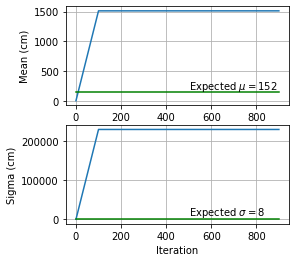

In [8]:
plot_mle_fit(iters, mus, sigmas, mu_text_y=200, sigma_text_y=10000)

What just happened? The estimated mean and standard deviation are nowhere close to our expected values of 152 and 50, but are instead very large numbers.

Let's try to tweak things a bit. We had randomly initialised mu and sigma with a value of 5. Now, let us initialise them somewhere in the neighborhood of our expected values. Let's say mu = 100 and sigma is 10.

In [9]:
# Let us initialise mu to 100 and sigma to 10
mu = Variable(torch.Tensor([100]).type(dtype), requires_grad=True)
sigma = Variable(torch.Tensor([10]).type(dtype), requires_grad=True)
iters, losses, mus, sigmas = optimise(X, mu, sigma, neg_log_likelihood, num_iters=500)

iter: 0, loss: 17.09115219116211, mu: 100.0, sigma: 10.0
iter: 50, loss: 4.972278594970703, mu: 118.44664001464844, sigma: 38.49307632446289
iter: 100, loss: 4.69744873046875, mu: 129.0364227294922, sigma: 33.65632247924805
iter: 150, loss: 4.295865058898926, mu: 139.37002563476562, sigma: 24.12705421447754
iter: 200, loss: 3.511776924133301, mu: 151.1002960205078, sigma: 8.47098159790039
iter: 250, loss: 3.502779722213745, mu: 152.05128479003906, sigma: 8.035272598266602
iter: 300, loss: 3.502779722213745, mu: 152.0514678955078, sigma: 8.035273551940918
iter: 350, loss: 3.502779722213745, mu: 152.0514678955078, sigma: 8.035273551940918
iter: 400, loss: 3.502779722213745, mu: 152.0514678955078, sigma: 8.035273551940918
iter: 450, loss: 3.502779722213745, mu: 152.0514678955078, sigma: 8.035273551940918


Our model has converged! The loss has decreased and the estimated $\mu$ and $\sigma$ are close to 152 and 50 respectively. The initial values of $\mu$ and $\sigma$ played a crucial role in helping the model converge. We were lucky this time because we knew what to expect for $\mu$ and $\sigma$. However, this is typically not the case in real world scenarios. Is there a better way to solve this problem? This is where Maximum A Posterior (MAP) estimation comes into play.

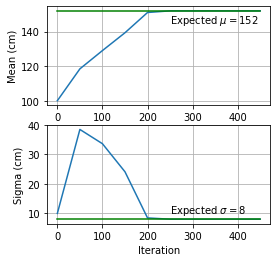

In [10]:
plot_mle_fit(iters, mus, sigmas, mu_text_y=145, sigma_text_y=10)

## Maximum A Posteriori (MAP) Estimation

Instead of maximizing $p(X|\theta)$, we can directly maximize $p(\theta|X)$ -> the probability of the parameters given the data instances.

Using bayes theorem, $$p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)}$$

Maximizing $p(\theta|X)$ is equivalent to maximizing the numerator of the above expression because the denominator is independent of $\theta$. $p(X|\theta)$ is what we maximized in MLE. We need to estimate $p(\theta)$, which is also called the prior probability. A popular approach is to say that we want the parameters to be as small as possible. Hence, we assume that $p(\theta)$ is proportional to $e^{-\theta^2}$. Refer to the chapter in the book for details. 

Maximizing $p(\theta|X)$ is equivalent to minimizing $-\log p(\theta|X)$

$$ -\log p(\theta|X) = -\log p(X|\theta) - \log p(\theta) = \frac{N}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}\sum_{i=1}^n(x_i - \mu)^2 + \mu^2 + \sigma ^ 2 $$

This is the same function as the negative log-likelihood discussed in MLE with two additional terms, $\mu^2$ and $\sigma^2$. They act as regularizers and prevent the parameters from exploding by penalizing large values of $\mu$ and $\sigma$.

In [11]:
# Here we add two additional parameters to the loss function namely mu^2 and sigma^2
# These parameter terms act as regularizers that penalise large values of mu and sigma.
def neg_log_likelihood_regularized(X, mu, sigma, k=0.2):
    """
    k is the regularization factor that controls the weight of the regularization loss
    """
    N = X.shape[0]
    X_minus_mu = torch.sub(X, mu)
    loss_likelihood = torch.mul(0.5 * N, torch.log(2 * np.pi * torch.pow(sigma, 2))) + \
           torch.div(torch.matmul(X_minus_mu.T, X_minus_mu), 2 * torch.pow(sigma, 2))
    loss_reg = k * (torch.pow(mu, 2) + torch.pow(sigma, 2))
    return loss_likelihood + loss_reg 

In [12]:
# Let us run the optimiser with the regularise log likelihood function
mu = Variable(torch.Tensor([1]).type(dtype), requires_grad=True)
sigma = Variable(torch.Tensor([1]).type(dtype), requires_grad=True)
iters, losses, mus, sigmas = optimise(X, mu, sigma, loss_fn=neg_log_likelihood_regularized, num_iters=30000, lr=0.001)

iter: 0, loss: 11441.4794921875, mu: 1.0, sigma: 1.0
iter: 3000, loss: 95028.9765625, mu: 455.33184814453125, sigma: 68924.875
iter: 6000, loss: 8626.001953125, mu: 137.10964965820312, sigma: 20754.236328125
iter: 9000, loss: 790.3759765625, mu: 41.306217193603516, sigma: 6247.73046875
iter: 12000, loss: 78.79613494873047, mu: 12.747103691101074, sigma: 1875.29541015625
iter: 15000, loss: 13.196127891540527, mu: 7.662848949432373, sigma: 544.9798583984375
iter: 18000, loss: 6.360317230224609, mu: 55.84259796142578, sigma: 117.35151672363281
iter: 21000, loss: 3.9652726650238037, mu: 151.65988159179688, sigma: 8.034442901611328
iter: 24000, loss: 3.9652726650238037, mu: 151.65988159179688, sigma: 8.034442901611328
iter: 27000, loss: 3.9652726650238037, mu: 151.65988159179688, sigma: 8.034442901611328


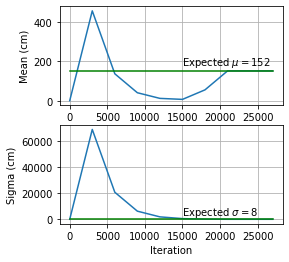

In [13]:
plot_mle_fit(iters, mus, sigmas, mu_text_y=180, sigma_text_y=3000)

As we can see, the model has converged and the estimated parameters are close to what we expected them to be.